<a href="https://colab.research.google.com/github/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial124_multiclass_semantic_segmentation_using_pre_trained_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video link: https://youtu.be/J4SORzikC5I

**Multiclass semantic segmentation - Using pre-trained networks as encoders**

(Same content as in tutorial 119 but this time using pre-trained networks as encoders) <p>
The dataset used in this video can be downloaded from the link below. This dataset can be used to train and test machine learning algorithms designed for multiclass semantic segmentation. Please read the Readme document for more information. 
https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view?usp=sharing

To annotate your own images, please visit www.apeer.com
<p>

**Segmentation Models Library**

https://github.com/qubvel/segmentation_models

<p>
pip install -U segmentation-models
<p>
Note: Importing segmentation models library may give you generic_utils 
error on TF2.x <p>
Watch this video to fix the error in Anaconda or colab.

https://youtu.be/syJZxDtLujs

<p>
For colab: When the error shows up, click the __init__.py link in the error message and change..

keras.utils.generic_utils.get_custom_objects().update(custom_objects) 
<p>to<p> 
keras.utils.get_custom_objects().update(custom_objects) 

<p>
Similarly if you get other errors you can make appropriate edits. For example, in Tensorflow 2.0 or later, you import utils the following way:
<p>
tensorflow.keras.utils.get_file (or just keras.utils.get_file).
<p>
If you get an error about keras_utils while you define the model with imagener weights, fix it by clicking on the link in the error and editing the weights_path. (If you are changing the code in the error file (weights.py) to add tensorflow.keras.utils then do not forget to add import tensorflow to that file. 
<p>
Restart runtime after making any changes. 


In [ ]:
!pip install -U segmentation-models

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.7/dist-packages (1.0.1)


In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.5.0
2.5.0


In [ ]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation
num_images = 50  #Total 1600 available

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/*.tif")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 1) for image in image_names_subset] #SM backbones use 3 channel images, so let us read images in color.
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/masks/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)


In [ ]:
print("Total images in the original dataset are: ", len(image_names))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  1600
Image data shape is:  (50, 128, 128, 3)
Mask data shape is:  (50, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [1 2 3 4]


In [ ]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [ ]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(50, 128, 128, 1)


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

In [ ]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
print(y_train_cat.shape)

(40, 128, 128, 4)


In [ ]:
#Reused parameters in all models
import tensorflow
n_classes=4
activation='softmax'

LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
###Model 
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_processed = preprocess_input(X_train)
X_test_processed = preprocess_input(X_test)


In [ ]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model.summary())

In [ ]:
history=model.fit(X_train_processed, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test_processed, y_test_cat))


model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/res34_backbone_n_epochs.hdf5')

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model = load_model('/content/drive/MyDrive/Colab Notebooks/saved_models/res34_backbone_50epochs.hdf5', compile=False)


In [ ]:
#IOU
from keras.metrics import MeanIoU
y_pred=model.predict(X_test_processed)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.91944844


In [ ]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

#

[[1.34870e+04 2.41000e+02 2.45000e+02 0.00000e+00]
 [3.96000e+02 1.53890e+04 4.24000e+02 0.00000e+00]
 [2.90000e+02 2.12800e+03 1.28647e+05 1.10000e+01]
 [0.00000e+00 0.00000e+00 1.09000e+02 2.47300e+03]]
IoU for class1 is:  0.92004913
IoU for class2 is:  0.82834536
IoU for class3 is:  0.97567767
IoU for class4 is:  0.9537216


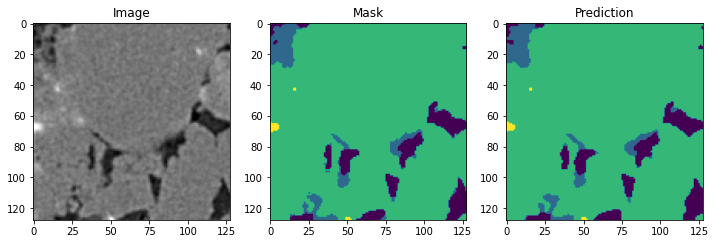

In [ ]:
import random
img_number = random.randint(0, len(X_test_processed)-1)
img = X_test_processed[img_number]
mask = y_test[img_number]
prediction = y_pred_argmax[img_number]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()